# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [3]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [11]:
components = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())
absorbing = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

In [12]:
def random_walk(G, iterations):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0:
            n = np.random.choice(neighbours)
        
    return pages_count

In [13]:
def print_page_counts(counts):
    for i in range(len(counts)):
        print(i, ':', counts[i])

In [27]:
iterations = 1000

print_page_counts(random_walk(components, iterations))

0 : 282.0
1 : 282.0
2 : 282.0
3 : 154.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0


In [28]:
print_page_counts(random_walk(absorbing, iterations))

0 : 0.0
1 : 996.0
2 : 2.0
3 : 2.0
4 : 0.0


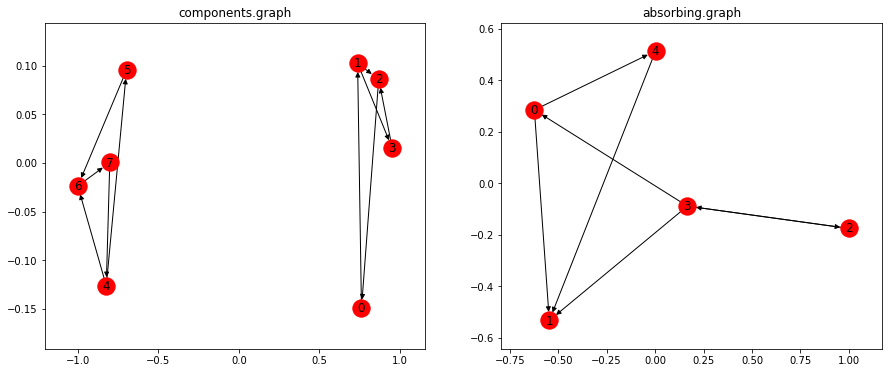

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("components.graph")
nx.draw_networkx(components, arrows=True)

plt.subplot(1,2,2)
plt.title("absorbing.graph")
nx.draw_networkx(absorbing, arrows=True)

### Explanation
The components graph has two separate connected components. Therefore the random surfer will never leave the component that it randomly selected at the start.<br>
The absorbing graph has (as its name says) an absorbing node (node 1). Once the random surfer reaches this node, it will never leave it again.

#### Exercise 2.13

In [30]:
def random_walk_teleportation(G, iterations, teleportation_prob=.15):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0 and np.random.rand(1) > teleportation_prob:
            n = np.random.choice(neighbours)
        else:
            n = np.random.choice(G.nodes())
        
    return pages_count

In [31]:
print_page_counts(random_walk_teleportation(components, iterations))

0 : 146.0
1 : 140.0
2 : 153.0
3 : 75.0
4 : 126.0
5 : 82.0
6 : 147.0
7 : 131.0


In [32]:
print_page_counts(random_walk_teleportation(absorbing, iterations))

0 : 159.0
1 : 367.0
2 : 133.0
3 : 185.0
4 : 156.0


---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [46]:
wiki = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())
titles= []
with open('../data/wikipedia_titles.tsv') as tsvfile:
    titles = list(csv.reader(tsvfile, delimiter='\t'))[1:]

In [41]:
def H(graph):
    H = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
    edges = list(graph.edges)
    for u,v in edges:
        H[int(u)][int(v)] = 1 / len(list(graph.neighbors(u)))
    
    return H

In [42]:
def w(graph):
    nodes = list(graph.nodes)
    return np.array(list(map(lambda n : len(list(graph.neighbors(n))) < 1, nodes)))

In [43]:
def G(graph, teleportation=.15):
    N = graph.number_of_nodes()
    H_caret = H(graph) + np.ones((N, N)) * w(graph)[..., np.newaxis] / N
    return teleportation * H_caret + (1 - teleportation) * np.ones((N, N)) / N

In [9]:
def power_iteration(G, iterations):
    N = G.shape[1]
    pi = np.ones(N) / N
    
    for i in range(iterations):
        pi = np.dot(pi, G)
        pi /= np.linalg.norm(pi)
    
    return pi

In [124]:
page_rank = power_iteration(G(wiki), 10000)

In [125]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', page_rank[index], titles[index][1])

1 : 0.1301179399210477 United States
2 : 0.0915594978075939 United Kingdom
3 : 0.08213020709893927 England
4 : 0.07587040453502215 France
5 : 0.07341986757861871 Europe
6 : 0.06929111314831508 Biological classification
7 : 0.0629693283026976 Animal
8 : 0.060647109037963415 World War II
9 : 0.05972649455165224 London
10 : 0.059646744437520674 Germany


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [99]:
def find_index_of_title(title):
    for t in titles:
        if t[1] == title:
            return int(t[0])
    return -1

hist_math_index = find_index_of_title('History of mathematics')
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 3470


In [108]:
wiki_gamed = wiki.copy()
for i in range(300):
    wiki_gamed.add_edge(ranks[i], hist_math_index)
print(wiki_gamed.number_of_edges(), wiki.number_of_edges())

197356 197056


In [112]:
page_rank = power_iteration(G(wiki_gamed), 10000)

In [113]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', page_rank[index], titles[index][1])

1 : 0.7371980515869838 History of mathematics
2 : 0.08563284836098323 United States
3 : 0.060285667074651966 United Kingdom
4 : 0.05496352819512774 England
5 : 0.05086876920441688 France
6 : 0.04838437736609695 Europe
7 : 0.04562910923319787 Biological classification
8 : 0.041469874072544634 Animal
9 : 0.03995625648331212 World War II
10 : 0.03933001018949908 London


In [114]:
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 1


In [123]:
import operator

# Verify with networx implementation
pr = nx.pagerank(wiki)

sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
for i in range(10):
    index = int(sorted_pr[i][0])
    print(i+1, ':', sorted_pr[index], titles[index][1])

1 : ('4477', 2.711548210511914e-05) United States
2 : ('4594', 2.711548210511914e-05) United Kingdom
3 : ('2674', 0.0001312350869276337) France
4 : ('1155', 0.00014273493258812434) Europe
5 : ('2368', 0.00012204601109186235) Germany
6 : ('570', 0.00014964624021011422) England
7 : ('1153', 2.711548210511914e-05) World War II
8 : ('3255', 7.651443512491394e-05) Latin
9 : ('3389', 9.379211924180421e-05) India
10 : ('2316', 0.0001490124449958786) English language


In [121]:
hist_math_rank = int(np.where(sorted_pr==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

TypeError: only size-1 arrays can be converted to Python scalars